## 1.模型选择、过拟合和欠拟合

关于K折交叉验证，由于验证数据集不参与模型训练，训练数据不足时，难以预留大量验证数据，因此可以使用K折交叉验证。

### 1.1 L2范数应对过拟合(高维线性回归实验为例)

L2 norm of w: 14.153095245361328


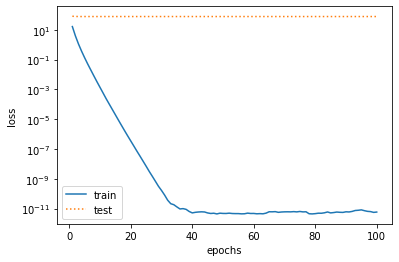

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
import matplotlib.pyplot as plt
#生成数据
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05
features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]
# 定义参数初始化函数，初始化模型参数并且附上梯度
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]
#定义l2罚项
def l2_penalty(w):
    return (w**2).sum()/2
#定义优化函数
def sgd(params,lr,batch_size):
    for param in params:
        param.data-=lr*param.grad/batch_size
#观察过拟合
batch_size, num_epochs, lr = 1, 100, 0.003
#定义模型y=W*X+b
def linreg(X,w,b):
    return torch.mm(X,w)+b
#定义损失函数
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size()))**2/2
#对损失函数进行可视化
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    # d2l.set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
net, loss = linreg,squared_loss
dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
#lambda为l2权重系数
def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())
fit_and_plot(lambd=0)

L2 norm of w: 0.03101830743253231


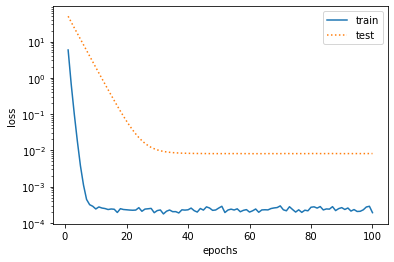

In [2]:
#带罚项训练集损失与测试集损失可视化
fit_and_plot(lambd=3)

### 1.2简洁实现

L2 norm of w: 13.147350311279297


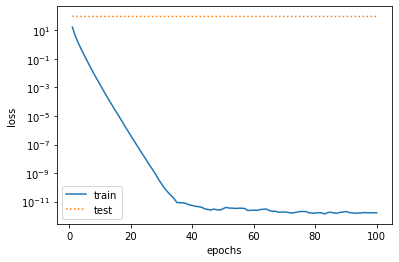

In [3]:
def fit_and_plot_pytorch(wd):
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())
fit_and_plot_pytorch(0)

L2 norm of w: 0.0324038565158844


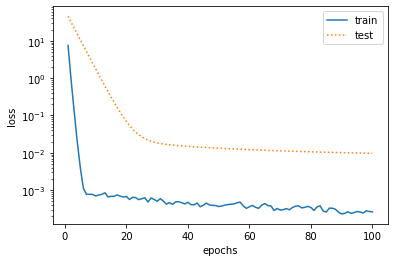

In [4]:
fit_and_plot_pytorch(3)

## 2.dropout 

### 2.1从零实现

In [5]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys

#定义dropout函数
def dropout(X,drop_prob):
    X=X.float()
    assert 0<=drop_prob<=1
    keep_prob=1-drop_prob
    if keep_prob==0:
        return torch.zero.like(X)
    mask=(torch.rand(X.shape)<keep_prob).float()
    return mask*X/keep_prob
# 参数的初始化
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]
drop_prob1, drop_prob2 = 0.2, 0.5
#定义模型
def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training:  # 只在训练模型时使用丢弃法
        H1 = dropout(H1, drop_prob1)  # 在第一层全连接后添加丢弃层
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)  # 在第二层全连接后添加丢弃层
    return torch.matmul(H2, W3) + b3
#计算准确率
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train() # 改回训练模式
        else: # 自定义的模型
            if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                # 将is_training设置成False
                acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
            else:
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
        n += y.shape[0]
    return acc_sum / n


num_epochs, lr, batch_size = 5, 100.0, 256  # 这里的学习率设置的很大，原因与之前相同。
loss = torch.nn.CrossEntropyLoss()


In [7]:
#加载数据，使用FashionMinist
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels
X_train, y_train = load_mnist('C:/Users/wangk/Desktop/DIVE_INTO_DEEP_LEARNING', kind='train')
X_test, y_test = load_mnist('C:/Users/wangk/Desktop/DIVE_INTO_DEEP_LEARNING', kind='t10k')

batch_size = 256

#转换数据
X_train = torch.tensor(X_train.reshape(60000,28,28), dtype=torch.float)
X_test = torch.tensor(X_test.reshape(10000,28,28), dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)
test_iter = torch.utils.data.DataLoader(dataset_test, batch_size, shuffle=True)

In [8]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step() 
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
train_ch3(net,train_iter,test_iter,loss,num_epochs,batch_size,params,lr)

### 2.2 简洁实现 

In [ ]:
#将图片铺平
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

net = nn.Sequential(
        FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(drop_prob1),
        nn.Linear(num_hiddens1, num_hiddens2), 
        nn.ReLU(),
        nn.Dropout(drop_prob2),
        nn.Linear(num_hiddens2, 10)
        )

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

## 3.梯度消失，梯度爆炸

(1)当神经网络的层数较多时，模型的数值稳定性容易变差

(2)协变量偏移：P(x)改变了而P(y|x)保持不变，例如对猫狗进行分类，训练集使用真实照片，测试集使用的卡通照片

(3)标签偏移：标签P(y)上边缘分布变化，但类条件分布是不变的P(x|y)，比如疾病诊断场景，病因(要预测的诊断结果)导致症状(观察的结果)

(4)概念偏移：对标签本身的定义发生变化

注：在数据量足够的情况下，确保训练数据集和测试集中的数据取自同一数据集，可以防止协变量偏移和标签便宜。但是如果数据量很少，少到测试集中存在训练集中未包含的标签，会发生标签偏移。

fold 0, train rmse 0.240330, valid rmse 0.221007
fold 1, train rmse 0.229578, valid rmse 0.270810
fold 2, train rmse 0.232571, valid rmse 0.238235
fold 3, train rmse 0.237298, valid rmse 0.218619
fold 4, train rmse 0.231883, valid rmse 0.259160
5-fold validation: avg train rmse 0.234332, avg valid rmse 0.241566


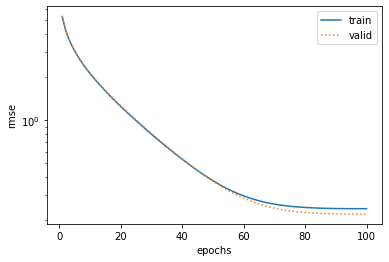

In [7]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    # d2l.set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
        
        
#读取数据
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
#归一化
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)
#转换数据
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)
#定义损失函数
loss = torch.nn.MSELoss()
#定义模型
def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net
#对数均方根损失
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()
#训练
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls
#k折交叉验证
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k
#模型选择
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

## 4.文本预处理

主要包括四个步骤：
读入文本——分词——建立字典，将每个词映射到唯一的索引——将文本从词的序列转换为索引的序列

In [ ]:
#读入文本
import collections
import re
def read_time_machine():
    with open('/home/kesci/input/timemachine7163/timemachine.txt', 'r') as f:
        lines = [re.sub('[^a-z]+', ' ', line.strip().lower()) for line in f]
    return lines
lines = read_time_machine()
print('# sentences %d' % len(lines))
#分词
def tokenize(sentences, token='word'):
    """将句子转换为词"""
    if token == 'word':
        return [sentence.split(' ') for sentence in sentences]
    elif token == 'char':
        return [list(sentence) for sentence in sentences]
    else:
        print('ERROR: unkown token type '+token)

tokens = tokenize(lines)
tokens[0:2]

### 建立字典

为了方便模型处理，将字符串转换为数字，构建字典，将每个词映射到唯一的索引编号

In [ ]:
class Vocab(object):
    def __init__(self, tokens, min_freq=0, use_special_tokens=False):
        counter = count_corpus(tokens)  # : 
        self.token_freqs = list(counter.items())
        self.idx_to_token = []
        if use_special_tokens:
            # padding, begin of sentence, end of sentence, unknown
            self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
            self.idx_to_token += ['', '', '', '']
        else:
            self.unk = 0
            self.idx_to_token += ['']
        self.idx_to_token += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in self.idx_to_token]
        self.token_to_idx = dict()
        for idx, token in enumerate(self.idx_to_token):
            self.token_to_idx[token] = idx

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(sentences):
    tokens = [tk for st in sentences for tk in st]
    return collections.Counter(tokens)  # 返回一个字典，记录每个词的出现次数


vocab = Vocab(tokens)

In [ ]:
#使用现有分词工具
#spacy分词工具
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(text)
print([token.text for token in doc])
#nltk分词工具
from nltk.tokenize import word_tokenize
from nltk import data
data.path.append('/home/kesci/input/nltk_data3784/nltk_data')
print(word_tokenize(text))